In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


In [27]:
import yfinance as yf
import pandas as pd

In [28]:
sp500=yf.download('SPY')

[*********************100%%**********************]  1 of 1 completed


In [29]:
sp500.index = pd.to_datetime(sp500.index)

In [30]:
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763733,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.939850,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.992699,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.256901,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.362564,531500
...,...,...,...,...,...,...
2024-04-01,523.830017,524.380005,520.969971,522.159973,522.159973,62477500
2024-04-02,518.239990,518.979980,516.479980,518.840027,518.840027,74230300
2024-04-03,517.719971,520.950012,517.669983,519.409973,519.409973,59155800


<Axes: xlabel='Date'>

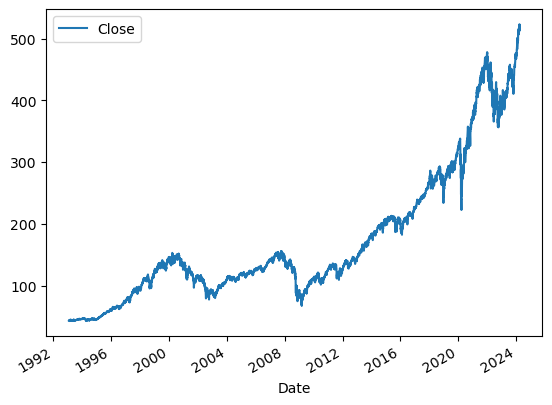

In [31]:
sp500.plot.line(y="Close", use_index=True)

In [32]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [33]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [34]:
sp500 = sp500.loc["1990-01-01":].copy()

In [35]:
close_data = sp500.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)


7460


In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sp500)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [37]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [38]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.summary


<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000001EDF0BD7F70>>

In [44]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(x_train,
					y_train,
					epochs=10)


Epoch 1/10
232/232 [==============================] - 47s 135ms/step - loss: 1.5864e-04
Epoch 2/10
232/232 [==============================] - 32s 136ms/step - loss: 8.4227e-05
Epoch 3/10
232/232 [==============================] - 31s 135ms/step - loss: 9.2341e-05
Epoch 4/10
232/232 [==============================] - 31s 135ms/step - loss: 9.3270e-05
Epoch 5/10
232/232 [==============================] - 32s 139ms/step - loss: 7.8470e-05
Epoch 6/10
232/232 [==============================] - 32s 137ms/step - loss: 6.7416e-05
Epoch 7/10
232/232 [==============================] - 32s 138ms/step - loss: 5.9481e-05
Epoch 8/10
232/232 [==============================] - 31s 135ms/step - loss: 5.4134e-05
Epoch 9/10
232/232 [==============================] - 31s 135ms/step - loss: 4.4666e-05
Epoch 10/10
232/232 [==============================] - 31s 135ms/step - loss: 5.5825e-05


In [46]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test_mean = np.mean(y_test[np.isfinite(y_test).all(axis=1)])

# Replace missing values in y_test with mean
y_test_filled = y_test.copy()
y_test_filled[np.isnan(y_test_filled)] = y_test_mean
y_test_filled[np.isinf(y_test_filled)] = y_test_mean
# Predict the testing data
predictions = model.predict(x_test)

# Reshape predictions before inverse transformation
predictions = np.reshape(predictions, (predictions.shape[0], 1))  # Fix the shape mismatch

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions)

# Evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


13/13 [==============================] - 1s 43ms/step
MSE nan
RMSE nan


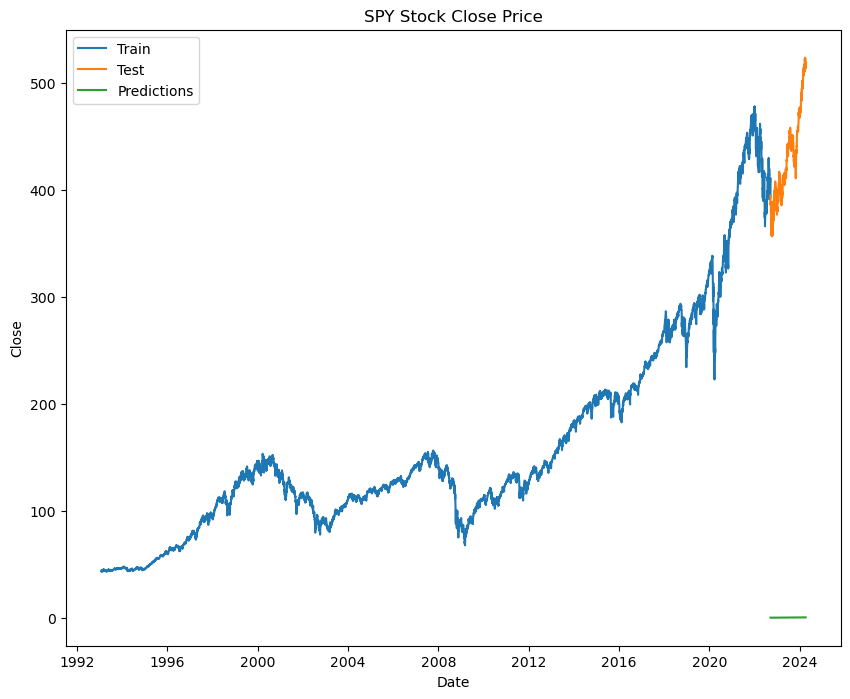

In [47]:
train = sp500[:training]
test = sp500[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot( train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.title('SPY Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
